In [6]:
X = np.matrix('0 1; 1 0')##definition of the Pauli matrices
Z = np.matrix('1 0; 0 -1')
Y = np.matrix('0 -1j; 1j 0') 
I = np.matrix('1 0; 0 1')
ket_plus = 1/np.sqrt(2)*np.matrix('1;1') ##ket(+)
ket_minus = 1/np.sqrt(2)*np.matrix('1;-1') ##Ket(-)
ket0 = np.matrix('1;0') ##Ket(0)
ket1 = np.matrix('0;1') ##Ket(1)

In [8]:
def BB84(P,rho):##P is the probability between 0 and 1,rho is the input density operator of 1 qubit case (2*2 matrix)
    return ((1-P)**2*rho+P*(1-P)*X*rho*X+P*(1-P)*Z*rho*Z+P**2*Y*rho*Y).T

In [16]:
def D(rho):
    return 0.5*rho+0.5*Z*rho*Z

In [10]:
def SupB(P,rho):
    rho_plus=np.matmul(ket_plus,ket_plus.conj().T) 
    rho_minus=np.matmul(ket_minus,ket_minus.conj().T)
    F=(1-P)**2*np.exp(-1j*1)*I+P*(1-P)*np.exp(-1j*5)*X+P*(1-P)*np.exp(-1j*3.986e+00)*Z+P**2*np.exp(-1j*5.270e+00)*Y##Vacuum Interference Operator after applying tranpose map
    return np.kron(0.5*(BB84(P,rho)+np.matmul(F,np.matmul(rho,F.conj().T))),rho_plus)+np.kron(0.5*(BB84(P,rho)-np.matmul(F,np.matmul(rho,F.conj().T))),rho_minus)

In [28]:
def SupD(rho):
    rho_plus=np.matmul(ket_plus,ket_plus.conj().T) 
    rho_minus=np.matmul(ket_minus,ket_minus.conj().T)
    F=0.5*np.exp(-1j*1)*I+0.5*np.exp(-1j*5)*Z##Vacuum Interference Operator after applying tranpose map
    return np.kron(0.5*(D(rho)+np.matmul(F,np.matmul(rho,F.conj().T))),rho_plus)+np.kron(0.5*(D(rho)-np.matmul(F,np.matmul(rho,F.conj().T))),rho_minus)

In [30]:
choi=np.kron(np.matmul(ket0,ket0.conj().T),(SupD(np.matmul(ket0,ket0.conj().T))).T)+np.kron(np.matmul(ket0,ket1.conj().T),(SupD(np.matmul(ket0,ket1.conj().T))).T)+np.kron(np.matmul(ket1,ket0.conj().T),(SupD(np.matmul(ket1,ket0.conj().T))).T)+np.kron(np.matmul(ket1,ket1.conj().T),(SupD(np.matmul(ket1,ket1.conj().T))).T)

In [18]:
choi=np.kron(np.matmul(ket0,ket0.conj().T),D(np.matmul(ket0,ket0.conj().T)))+np.kron(np.matmul(ket0,ket1.conj().T),D(np.matmul(ket0,ket1.conj().T)))+np.kron(np.matmul(ket1,ket0.conj().T),D(np.matmul(ket1,ket0.conj().T)))+np.kron(np.matmul(ket1,ket1.conj().T),D(np.matmul(ket1,ket1.conj().T)))

In [32]:
from __future__ import annotations
import copy as _copy
from numbers import Number
import numpy as np

from qiskit import _numpy_compat
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.circuit.instruction import Instruction
from qiskit.exceptions import QiskitError
from qiskit.quantum_info.states.quantum_state import QuantumState
from qiskit.quantum_info.operators.mixins.tolerances import TolerancesMixin
from qiskit.quantum_info.operators.op_shape import OpShape
from qiskit.quantum_info.operators.operator import Operator
from qiskit.quantum_info.operators.symplectic import Pauli, SparsePauliOp
from qiskit.quantum_info.operators.scalar_op import ScalarOp
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.quantum_info.operators.predicates import is_positive_semidefinite_matrix
from qiskit.quantum_info.operators.channel.quantum_channel import QuantumChannel
from qiskit.quantum_info.operators.channel.superop import SuperOp

from qiskit._accelerate.pauli_expval import density_expval_pauli_no_x, density_expval_pauli_with_x
from qiskit.quantum_info.states.statevector import Statevector
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix, Operator
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as ply
##Import some packages

import logging
import warnings
import numpy as np

# This code is part of Qiskit.
#
# (C) Copyright IBM 2017.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""
A collection of useful quantum information functions for operators.
"""

import logging
import warnings
import numpy as np

from qiskit.exceptions import QiskitError, MissingOptionalLibraryError
from qiskit.circuit.gate import Gate
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.quantum_info.operators.operator import Operator
from qiskit.quantum_info.operators.channel.quantum_channel import QuantumChannel
from qiskit.quantum_info.operators.channel import Choi, SuperOp
from qiskit.quantum_info.states.densitymatrix import DensityMatrix
from qiskit.quantum_info.states.measures import state_fidelity
from qiskit.utils import optionals as _optionals

logger = logging.getLogger(__name__)


def process_fidelity(channel, target=None, require_cp=True, require_tp=True):
    r"""Return the process fidelity of a noisy quantum channel.


    The process fidelity :math:`F_{\text{pro}}(\mathcal{E}, \mathcal{F})`
    between two quantum channels :math:`\mathcal{E}, \mathcal{F}` is given by

    .. math::
        F_{\text{pro}}(\mathcal{E}, \mathcal{F})
            = F(\rho_{\mathcal{E}}, \rho_{\mathcal{F}})

    where :math:`F` is the :func:`~qiskit.quantum_info.state_fidelity`,
    :math:`\rho_{\mathcal{E}} = \Lambda_{\mathcal{E}} / d` is the
    normalized :class:`~qiskit.quantum_info.Choi` matrix for the channel
    :math:`\mathcal{E}`, and :math:`d` is the input dimension of
    :math:`\mathcal{E}`.

    When the target channel is unitary this is equivalent to

    .. math::
        F_{\text{pro}}(\mathcal{E}, U)
            = \frac{Tr[S_U^\dagger S_{\mathcal{E}}]}{d^2}

    where :math:`S_{\mathcal{E}}, S_{U}` are the
    :class:`~qiskit.quantum_info.SuperOp` matrices for the *input* quantum
    channel :math:`\mathcal{E}` and *target* unitary :math:`U` respectively,
    and :math:`d` is the input dimension of the channel.

    Args:
        channel (Operator or QuantumChannel): input quantum channel.
        target (Operator or QuantumChannel or None): target quantum channel.
            If `None` target is the identity operator [Default: None].
        require_cp (bool): check if input and target channels are
                           completely-positive and if non-CP log warning
                           containing negative eigenvalues of Choi-matrix
                           [Default: True].
        require_tp (bool): check if input and target channels are
                           trace-preserving and if non-TP log warning
                           containing negative eigenvalues of partial
                           Choi-matrix :math:`Tr_{\mbox{out}}[\mathcal{E}] - I`
                           [Default: True].

    Returns:
        float: The process fidelity :math:`F_{\text{pro}}`.

    Raises:f'c
        QiskitError: if the channel and target do not have the same dimensions.
    """
    # Format inputs
    channel = _input_formatter(channel, SuperOp, "process_fidelity", "channel")
    target = _input_formatter(target, Operator, "process_fidelity", "target")

    if target:
        # Validate dimensions
        if channel.dim != target.dim:
            raise QiskitError(
                "Input quantum channel and target unitary must have the same "
                "dimensions ({} != {}).".format(channel.dim, target.dim)
            )

    # Validate complete-positivity and trace-preserving
    for label, chan in [("Input", channel), ("Target", target)]:
        if chan is not None and require_cp:
            cp_cond = _cp_condition(chan)
            neg = cp_cond < -1 * chan.atol
            if np.any(neg):
                logger.warning(
                    "%s channel is not CP. Choi-matrix has negative eigenvalues: %s",
                    label,
                    cp_cond[neg],
                )
        if chan is not None and require_tp:
            tp_cond = _tp_condition(chan)
            non_zero = np.logical_not(np.isclose(tp_cond, 0, atol=chan.atol, rtol=chan.rtol))
            if np.any(non_zero):
                logger.warning(
                    "%s channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: %s",
                    label,
                    tp_cond[non_zero],
                )

    if isinstance(target, Operator):
        # Compute fidelity with unitary target by applying the inverse
        # to channel and computing fidelity with the identity
        channel = channel.compose(target.adjoint())
        target = None

    input_dim, _ = channel.dim
    if target is None:
        # Compute process fidelity with identity channel
        if isinstance(channel, Operator):
            # |Tr[U]/dim| ** 2
            fid = np.abs(np.trace(channel.data) / input_dim) ** 2
        else:
            # Tr[S] / (dim ** 2)
            fid = np.trace(SuperOp(channel).data) / (input_dim**2)
        return float(np.real(fid))

    # For comparing two non-unitary channels we compute the state fidelity of
    # the normalized Choi-matrices. This is equivalent to the previous definition
    # when the target is a unitary channel.
    state1 = DensityMatrix(Choi(channel).data / input_dim)
    state2 = DensityMatrix(Choi(target).data / input_dim)
    return state_fidelity(state1, state2, validate=False)


def average_gate_fidelity(channel, target=None, require_cp=True, require_tp=False):
    r"""Return the average gate fidelity of a noisy quantum channel.

    The average gate fidelity :math:`F_{\text{ave}}` is given by

    .. math::
        F_{\text{ave}}(\mathcal{E}, U)
            &= \int d\psi \langle\psi|U^\dagger
                \mathcal{E}(|\psi\rangle\!\langle\psi|)U|\psi\rangle \\
            &= \frac{d F_{\text{pro}}(\mathcal{E}, U) + 1}{d + 1}

    where :math:`F_{\text{pro}}(\mathcal{E}, U)` is the
    :meth:`~qiskit.quantum_info.process_fidelity` of the input quantum
    *channel* :math:`\mathcal{E}` with a *target* unitary :math:`U`, and
    :math:`d` is the dimension of the *channel*.

    Args:
        channel (QuantumChannel or Operator): noisy quantum channel.
        target (Operator or None): target unitary operator.
            If `None` target is the identity operator [Default: None].
        require_cp (bool): check if input and target channels are
                           completely-positive and if non-CP log warning
                           containing negative eigenvalues of Choi-matrix
                           [Default: True].
        require_tp (bool): check if input and target channels are
                           trace-preserving and if non-TP log warning
                           containing negative eigenvalues of partial
                           Choi-matrix :math:`Tr_{\mbox{out}}[\mathcal{E}] - I`
                           [Default: True].

    Returns:
        float: The average gate fidelity :math:`F_{\text{ave}}`.

    Raises:
        QiskitError: if the channel and target do not have the same dimensions,
                     or have different input and output dimensions.
    """
    # Format inputs
    channel = _input_formatter(channel, SuperOp, "average_gate_fidelity", "channel")
    target = _input_formatter(target, Operator, "average_gate_fidelity", "target")

    if target is not None:
        try:
            target = Operator(target)
        except QiskitError as ex:
            raise QiskitError(
                "Target channel is not a unitary channel. To compare "
                "two non-unitary channels use the "
                "`qiskit.quantum_info.process_fidelity` function instead."
            ) from ex
    dim, _ = channel.dim
    f_pro = process_fidelity(channel, target=target, require_cp=require_cp, require_tp=require_tp)
    return (dim * f_pro + 1) / (dim + 1)


def gate_error(channel, target=None, require_cp=True, require_tp=False):
    r"""Return the gate error of a noisy quantum channel.

    The gate error :math:`E` is given by the average gate infidelity

    .. math::
        E(\mathcal{E}, U) = 1 - F_{\text{ave}}(\mathcal{E}, U)

    where :math:`F_{\text{ave}}(\mathcal{E}, U)` is the
    :meth:`~qiskit.quantum_info.average_gate_fidelity` of the input
    quantum *channel* :math:`\mathcal{E}` with a *target* unitary
    :math:`U`.

    Args:
        channel (QuantumChannel): noisy quantum channel.
        target (Operator or None): target unitary operator.
            If `None` target is the identity operator [Default: None].
        require_cp (bool): check if input and target channels are
                           completely-positive and if non-CP log warning
                           containing negative eigenvalues of Choi-matrix
                           [Default: True].
        require_tp (bool): check if input and target channels are
                           trace-preserving and if non-TP log warning
                           containing negative eigenvalues of partial
                           Choi-matrix :math:`Tr_{\mbox{out}}[\mathcal{E}] - I`
                           [Default: True].

    Returns:
        float: The average gate error :math:`E`.

    Raises:
        QiskitError: if the channel and target do not have the same dimensions,
                     or have different input and output dimensions.
    """
    # Format inputs
    channel = _input_formatter(channel, SuperOp, "gate_error", "channel")
    target = _input_formatter(target, Operator, "gate_error", "target")
    return 1 - average_gate_fidelity(
        channel, target=target, require_cp=require_cp, require_tp=require_tp
    )


def diamond_norm(choi, **kwargs):
    r"""Return the diamond norm of the input quantum channel object.

    This function computes the completely-bounded trace-norm (often
    referred to as the diamond-norm) of the input quantum channel object
    using the semidefinite-program from reference [1].

    Args:
        choi(Choi or QuantumChannel): a quantum channel object or
                                      Choi-matrix array.
        kwargs: optional arguments to pass to CVXPY solver.

    Returns:
        float: The completely-bounded trace norm
               :math:`\|\mathcal{E}\|_{\diamond}`.

    Raises:
        QiskitError: if CVXPY package cannot be found.

    Additional Information:
        The input to this function is typically *not* a CPTP quantum
        channel, but rather the *difference* between two quantum channels
        :math:`\|\Delta\mathcal{E}\|_\diamond` where
        :math:`\Delta\mathcal{E} = \mathcal{E}_1 - \mathcal{E}_2`.

    Reference:
        J. Watrous. "Simpler semidefinite programs for completely bounded
        norms", arXiv:1207.5726 [quant-ph] (2012).

    .. note::

        This function requires the optional CVXPY package to be installed.
        Any additional kwargs will be passed to the ``cvxpy.solve``
        function. See the CVXPY documentation for information on available
        SDP solvers.
    """
    from scipy import sparse

    cvxpy = _cvxpy_check("`diamond_norm`")  # Check CVXPY is installed

    choi = Choi(_input_formatter(choi, Choi, "diamond_norm", "choi"))

    def cvx_bmat(mat_r, mat_i):
        """Block matrix for embedding complex matrix in reals"""
        return cvxpy.bmat([[mat_r, -mat_i], [mat_i, mat_r]])

    # Dimension of input and output spaces
    dim_in = choi._input_dim
    dim_out = choi._output_dim
    size = dim_in * dim_out

    # SDP Variables to convert to real valued problem
    r0_r = cvxpy.Variable((dim_in, dim_in))
    r0_i = cvxpy.Variable((dim_in, dim_in))
    r0 = cvx_bmat(r0_r, r0_i)

    r1_r = cvxpy.Variable((dim_in, dim_in))
    r1_i = cvxpy.Variable((dim_in, dim_in))
    r1 = cvx_bmat(r1_r, r1_i)

    x_r = cvxpy.Variable((size, size))
    x_i = cvxpy.Variable((size, size))
    iden = sparse.eye(dim_out)

    # Watrous uses row-vec convention for his Choi matrix while we use
    # col-vec. It turns out row-vec convention is requried for CVXPY too
    # since the cvxpy.kron function must have a constant as its first argument.
    c_r = cvxpy.bmat([[cvxpy.kron(iden, r0_r), x_r], [x_r.T, cvxpy.kron(iden, r1_r)]])
    c_i = cvxpy.bmat([[cvxpy.kron(iden, r0_i), x_i], [-x_i.T, cvxpy.kron(iden, r1_i)]])
    c = cvx_bmat(c_r, c_i)

    # Convert col-vec convention Choi-matrix to row-vec convention and
    # then take Transpose: Choi_C -> Choi_R.T
    choi_rt = np.transpose(
        np.reshape(choi.data, (dim_in, dim_out, dim_in, dim_out)), (3, 2, 1, 0)
    ).reshape(choi.data.shape)
    choi_rt_r = choi_rt.real
    choi_rt_i = choi_rt.imag

    # Constraints
    cons = [
        r0 >> 0,
        r0_r == r0_r.T,
        r0_i == -r0_i.T,
        cvxpy.trace(r0_r) == 1,
        r1 >> 0,
        r1_r == r1_r.T,
        r1_i == -r1_i.T,
        cvxpy.trace(r1_r) == 1,
        c >> 0,
    ]

    # Objective function
    obj = cvxpy.Maximize(cvxpy.trace(choi_rt_r @ x_r) + cvxpy.trace(choi_rt_i @ x_i))
    prob = cvxpy.Problem(obj, cons)
    sol = prob.solve(**kwargs)
    return sol


def _cvxpy_check(name):
    """Check that a supported CVXPY version is installed"""
    # Check if CVXPY package is installed
    _optionals.HAS_CVXPY.require_now(name)
    import cvxpy  # pylint: disable=import-error

    # Check CVXPY version
    version = cvxpy.__version__
    if version[0] != "1":
        raise MissingOptionalLibraryError(
            "CVXPY >= 1.0",
            "diamond_norm",
            msg=f"Incompatible CVXPY version {version} found.",
        )
    return cvxpy


# pylint: disable=too-many-return-statements
def _input_formatter(obj, fallback_class, func_name, arg_name):
    """Formatting function for input conversion"""
    # Empty input
    if obj is None:
        return obj

    # Channel-like input
    if isinstance(obj, QuantumChannel):
        return obj
    if hasattr(obj, "to_quantumchannel"):
        return obj.to_quantumchannel()
    if hasattr(obj, "to_channel"):
        return obj.to_channel()

    # Unitary-like input
    if isinstance(obj, (Gate, BaseOperator)):
        return Operator(obj)
    if hasattr(obj, "to_operator"):
        return obj.to_operator()

    warnings.warn(
        "Passing in a list or Numpy array to `{}` `{}` argument is "
        "deprecated as of 0.17.0 since the matrix representation cannot be inferred "
        "unambiguously. Use a Gate or BaseOperator subclass (eg. Operator, "
        "SuperOp, Choi) object instead.".format(func_name, arg_name),
        DeprecationWarning,
    )
    warnings.warn(f"Treating array input as a {fallback_class.__name__} object")
    return fallback_class(obj)


def _cp_condition(channel):
    """Return Choi-matrix eigenvalues for checking if channel is CP"""
    if isinstance(channel, QuantumChannel):
        if not isinstance(channel, Choi):
            channel = Choi(channel)
        return np.linalg.eigvalsh(channel.data)
    unitary = Operator(channel).data
    return np.tensordot(unitary, unitary.conj(), axes=([0, 1], [0, 1])).real


def _tp_condition(channel):
    """Return partial tr Choi-matrix eigenvalues for checking if channel is TP"""
    if isinstance(channel, QuantumChannel):
        if not isinstance(channel, Choi):
            channel = Choi(channel)
        choi = channel.data
        dims = tuple(np.sqrt(choi.shape).astype(int))
        shape = dims + dims
        tr_choi = np.trace(np.reshape(choi, shape), axis1=1, axis2=3)
    else:
        unitary = Operator(channel).data
        tr_choi = np.tensordot(unitary, unitary.conj(), axes=(0, 0))
    return np.linalg.eigvalsh(tr_choi - np.eye(len(tr_choi)))

def partial_transpose(self, qargs: list[int]) -> DensityMatrix:
        """Return partially transposed density matrix.

        Args:
            qargs (list): The subsystems to be transposed.

        Returns:
            DensityMatrix: The partially transposed density matrix.
        """
        arr = self._data.reshape(self._op_shape.tensor_shape)
        qargs = len(self._op_shape.dims_l()) - 1 - np.array(qargs)
        n = len(self.dims())
        lst = list(range(2 * n))
        for i in qargs:
            lst[i], lst[i + n] = lst[i + n], lst[i]
        rho = np.transpose(arr, lst)
        rho = np.reshape(rho, self._op_shape.shape)
        return DensityMatrix(rho, dims=self.dims())

##J=np.matrix("0.9,0,0,0.08;0,0.1,0.72,0;0,0.72,0.1,0;0.08,0,0,0.9")


choi=Choi(choi, input_dims=None, output_dims=None)


In [34]:
diamond_norm(choi)

0.9999984565835436

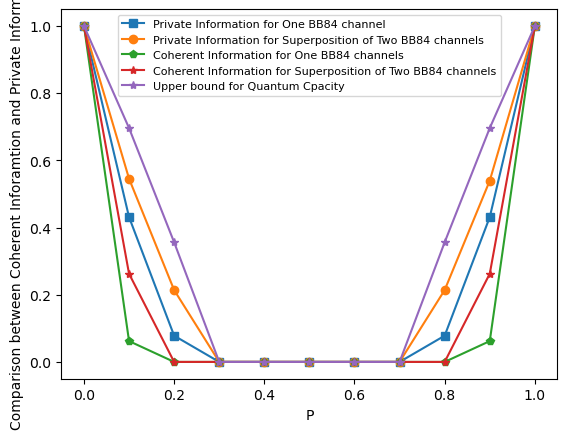

In [6]:
m1=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
a1=[0.9999999999980588,0.4310044064076264,0.07807190510919781,0,0,0,0,0,0.07807190511263595,0.4310044063984302,0.9999999999923324]
m2=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
a2=[0.9999999999703237,0.545411925320527,0.21392937675791335,0,0,0,0,0,0.21393553235245433,0.5393774475749149,0.9999999999618845]
m3=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
a3=[0.9999999999940516,0.06200881280187809,2.7909563549144423e-11,2.220446049250313e-16,3.613402699276236e-07,1.2716734332229862e-09,2.220446049250313e-16,1.1102230246251565e-15,-5.551115123125783e-16,0.06200881282142001,0.9999999999969549]
m4=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
a4=[0.999999999999952,0.2625029926621154,1.2382317393644371e-11,2.826960977908577e-05,0,0,-5.44212674924438e-10,-4.178990486991552e-11,-1.021467355144523e-10,0.2625029926979081,0.9998739845388571]
m5=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
a5=[0.999987,0.695994,0.356133,0,0,0,0,0,0.356144,0.695994,0.999987]
fig=ply.figure()
ax1 = fig.add_subplot(111)
ax1.plot(m1,a1,marker='s',label='Private Information for One BB84 channel')
ax1.plot(m2,a2,marker='o',label='Private Information for Superposition of Two BB84 channels')
ax1.plot(m3,a3,marker='p',label='Coherent Information for One BB84 channels')
ax1.plot(m4,a4,marker='*',label='Coherent Information for Superposition of Two BB84 channels')
ax1.plot(m5,a5,marker='*',label='Upper bound for Quantum Cpacity')
ply.legend(loc="best",prop={'size': 8})
ply.xlabel("P")
ply.ylabel("Comparison between Coherent Inforamtion and Private Information")
ply.show()